In [1]:
%matplotlib inline
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовується пристрій:", device)

Використовується пристрій: cuda


In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# створюємо каталоги для даних і моделей
os.makedirs('./data',   exist_ok=True)
os.makedirs('./models', exist_ok=True)

cifar_train = CIFAR10(root='./data', train=True,  download=True, transform=train_transform)
cifar_test  = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(cifar_train))
val_size   = len(cifar_train) - train_size
train_ds, val_ds = random_split(
    cifar_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,    batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class CNN(nn.Module):
    def __init__(self, num_filters, hidden_size, dropout_rate):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32→16
        )
        fc_in = num_filters * 16 * 16
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_in, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 10)
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [5]:
def evaluate_model(num_filters, hidden_size, dropout_rate):
    nf = int(round(num_filters))
    hs = int(round(hidden_size))
    dr = float(np.clip(dropout_rate, 0.0, 1.0))

    model = CNN(nf, hs, dr).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for _ in range(2):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            total   += y.size(0)
            correct += (preds == y).sum().item()

    # очистка
    del model
    torch.cuda.empty_cache()

    acc = correct / total
    return -acc

In [6]:
def custom_differential_evolution(bounds, maxiter=8, popsize=8, mutation=0.5, recomb=0.7):
    dims  = len(bounds)
    lows  = np.array([b[0] for b in bounds])
    highs = np.array([b[1] for b in bounds])

    pop     = np.random.uniform(lows, highs, size=(popsize, dims))
    fitness = np.array([evaluate_model(*ind) for ind in pop])

    for gen in range(1, maxiter+1):
        for i in range(popsize):
            idxs = [j for j in range(popsize) if j != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant  = np.clip(a + mutation*(b - c), lows, highs)

            mask = np.random.rand(dims) < recomb
            if not mask.any():
                mask[np.random.randint(0, dims)] = True
            trial = np.where(mask, mutant, pop[i])

            f = evaluate_model(*trial)
            if f < fitness[i]:
                pop[i], fitness[i] = trial, f

        best_acc = -fitness.min()
        print(f"Покоління {gen}: найкраща acc={best_acc:.4f}")

    idx = fitness.argmin()
    return pop[idx], -fitness[idx]

In [7]:
def train_and_plot(
    num_filters, hidden_size, dropout_rate,
    epochs=25, save_path="models/best_model.pth"
):
    model     = CNN(num_filters, hidden_size, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loss, train_acc = [], []
    val_loss,   val_acc   = [], []

    best_val_loss   = float('inf')
    best_state_dict = None

    for epoch in range(1, epochs+1):
        # TRAIN
        model.train()
        run_loss = corr = tot = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            run_loss += loss.item()
            preds = out.argmax(dim=1)
            tot  += y.size(0)
            corr += (preds == y).sum().item()

        train_loss.append(run_loss / len(train_loader))
        train_acc.append(corr / tot)

        # VALIDATION
        model.eval()
        val_run = val_corr = val_tot = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_run  += loss.item()
                preds    = out.argmax(dim=1)
                val_tot  += y.size(0)
                val_corr += (preds == y).sum().item()

        epoch_val_loss = val_run / len(val_loader)
        epoch_val_acc  = val_corr / val_tot
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        if epoch_val_loss < best_val_loss:
            best_val_loss   = epoch_val_loss
            best_state_dict = model.state_dict()

        print(f"Епоха {epoch}/{epochs} — "
              f"train_loss={train_loss[-1]:.4f}, train_acc={train_acc[-1]:.4f} | "
              f"val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.4f}")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(model.state_dict(), save_path)
        print(f"Найкраща модель збережена в {save_path}")

    # Графіки
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), train_loss, label="train_loss")
    plt.plot(range(1, epochs+1), val_loss,   label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), train_acc, label="train_acc")
    plt.plot(range(1, epochs+1), val_acc,   label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.suptitle("Training History")
    plt.show()
    plt.close()

    if device.type == 'cuda':
        torch.cuda.empty_cache()

    return {
        "model":      model,
        "train_loss": train_loss,
        "train_acc":  train_acc,
        "val_loss":   val_loss,
        "val_acc":    val_acc
    }

In [8]:
def evaluate_on_test(
    model: nn.Module,
    test_loader: DataLoader,
    save_path: str = "models/best_model.pth",
    detailed: bool = False
) -> float:
    if not os.path.isfile(save_path):
        print(f"Файл з моделлю не знайдено: {save_path}")
        return 0.0

    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()

    correct = total = 0
    start = time.perf_counter()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            total   += y.size(0)
            correct += (preds == y).sum().item()
            if detailed:
                all_preds.append(preds.cpu().numpy())
                all_labels.append(y.cpu().numpy())

    acc     = correct / total
    elapsed = time.perf_counter() - start
    print(f"Інференс: {elapsed:.2f}s — точність: {acc:.4f}")

    if detailed:
        from sklearn.metrics import classification_report, confusion_matrix
        y_true = np.concatenate(all_labels)
        y_pred = np.concatenate(all_preds)
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred))

    return acc

In [9]:
def plot_landscape(
    num_filters_range: tuple = (30, 100, 10),
    hidden_size_range: tuple = (100, 300, 50),
    dropout_rate: float = 0.25,
    show_contour: bool = True
):
    f_vals = np.arange(*num_filters_range)
    h_vals = np.arange(*hidden_size_range)
    F, H = np.meshgrid(f_vals, h_vals, indexing='ij')
    Acc = np.zeros_like(F, dtype=float)

    cache = {}
    for i in tqdm(range(F.shape[0]), desc="Filters"):
        for j in range(F.shape[1]):
            key = (int(F[i,j]), int(H[i,j]), dropout_rate)
            if key not in cache:
                cache[key] = -evaluate_model(*key)
            Acc[i, j] = cache[key]

    fig = plt.figure(figsize=(10,6))
    ax  = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(F, H, Acc, cmap='viridis', edgecolor='none', antialiased=True)
    fig.colorbar(surf, ax=ax, shrink=0.5, label='Accuracy')

    ax.set_xlabel('Num Filters')
    ax.set_ylabel('Hidden Size')
    ax.set_zlabel('Accuracy')
    ax.set_title(f'Ландшафт (dropout={dropout_rate})')

    if show_contour:
        ax.contour(F, H, Acc, zdir='z', offset=Acc.min(), cmap='viridis')

    plt.show()
    plt.close()

In [14]:
# 1) Оптимізація гіперпараметрів через DE
start = time.perf_counter()
best_params, best_acc = custom_differential_evolution(
    bounds=[(16,128),(64,256),(0.1,0.5)],
    maxiter=8, popsize=8
)
duration = time.perf_counter() - start
print(f"DE завершено за {duration:.2f}s — best acc={best_acc:.4f}")

Покоління 1: найкраща acc=0.5460
Покоління 2: найкраща acc=0.5460
Покоління 3: найкраща acc=0.5460
Покоління 4: найкраща acc=0.5581
Покоління 5: найкраща acc=0.5581
Покоління 6: найкраща acc=0.5614
Покоління 7: найкраща acc=0.5835
Покоління 8: найкраща acc=0.5835
DE завершено за 1962.66s — best acc=0.5835


Епоха 1/25 — train_loss=1.6127, train_acc=0.4295 | val_loss=1.3623, val_acc=0.5161
Епоха 2/25 — train_loss=1.3154, train_acc=0.5289 | val_loss=1.2136, val_acc=0.5712
Епоха 3/25 — train_loss=1.2003, train_acc=0.5718 | val_loss=1.1122, val_acc=0.6076
Епоха 4/25 — train_loss=1.1293, train_acc=0.5991 | val_loss=1.0795, val_acc=0.6216
Епоха 5/25 — train_loss=1.0815, train_acc=0.6146 | val_loss=1.0485, val_acc=0.6312
Епоха 6/25 — train_loss=1.0424, train_acc=0.6301 | val_loss=1.0415, val_acc=0.6317
Епоха 7/25 — train_loss=1.0038, train_acc=0.6438 | val_loss=1.0303, val_acc=0.6414
Епоха 8/25 — train_loss=0.9861, train_acc=0.6503 | val_loss=1.0211, val_acc=0.6426
Епоха 9/25 — train_loss=0.9519, train_acc=0.6615 | val_loss=1.0322, val_acc=0.6411
Епоха 10/25 — train_loss=0.9275, train_acc=0.6708 | val_loss=1.0400, val_acc=0.6390
Епоха 11/25 — train_loss=0.9091, train_acc=0.6777 | val_loss=1.0052, val_acc=0.6459
Епоха 12/25 — train_loss=0.8891, train_acc=0.6825 | val_loss=1.0017, val_acc=0.6480
Е

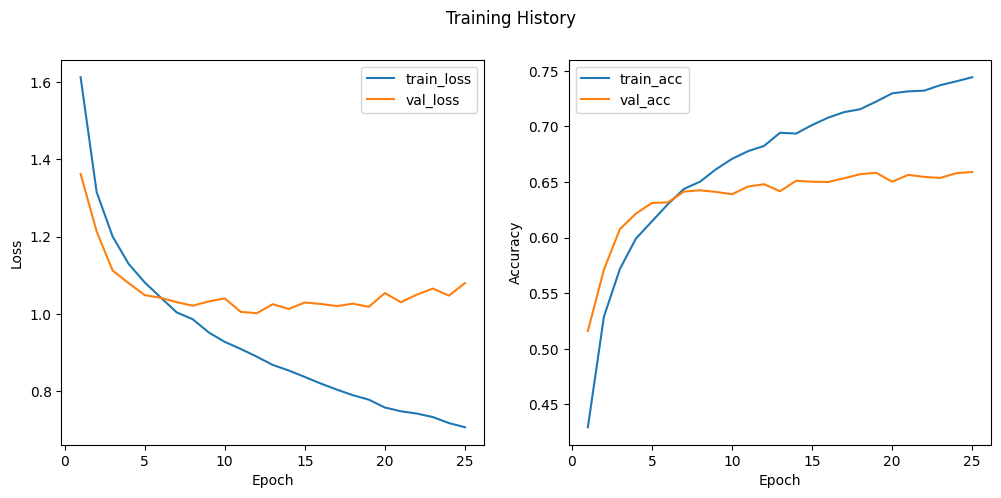

In [15]:
# 2) Фінальне тренування з кращими параметрами
tf, hs = map(lambda x: int(round(x)), best_params[:2])
dr = round(best_params[2], 2)
hist = train_and_plot(tf, hs, dr, epochs=25, save_path="models/best_model.pth")

In [16]:
# 3) Оцінка на тесті
best_model = hist["model"]
evaluate_on_test(best_model, test_loader, save_path="models/best_model.pth", detailed=False)

C:\Users\Artem\AppData\Local\Temp\ipykernel_1688\4267016550.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Інференс: 9.19s — точність: 0.6548


0.6548

Filters:   0%|          | 0/14 [00:00<?, ?it/s]

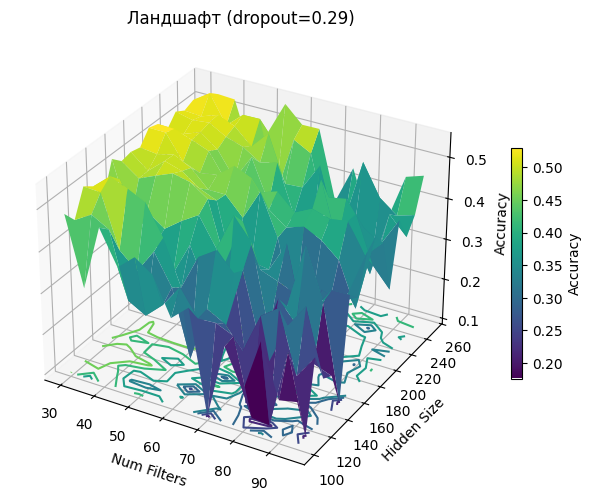

In [18]:
# 4) Побудова ландшафту
f_range = (30, 100, 5)     # Num Filters: 30,35,40,...,95
h_range = (100, 260, 10)   # Hidden Size: 100,110,...,250

plot_landscape(
    num_filters_range=f_range,
    hidden_size_range=h_range,
    dropout_rate=0.29,
    show_contour=True
)
